# Figure # - model fit

This notebook displays the results of the regression model for percent biophony and the sound exposure level (SEL).

#### Import statements

In [1]:
from pymc3 import Model, sample, Normal, Uniform, stats
from pymc3.backends import SQLite
from pymc3.backends.sqlite import load
from os import path

/Users/jake/miniconda3/envs/datawaves/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pandas
import numpy
import seaborn
from figutils import style
from matplotlib import pyplot
%matplotlib inline

#### formatting

In [3]:
style.set_font()

In [4]:
seaborn.set()

#### variable declarations

In [5]:
biophony_trace_filepath = "/Users/jake/OneDrive/Documents/alpine soundscapes/data/model traces/biophony"

In [6]:
sel_trace_filepath = "/Users/jake/OneDrive/Documents/alpine soundscapes/data/model traces/sel"

In [7]:
data_filepath = "/Users/jake/OneDrive/Documents/alpine soundscapes/data/dataset.csv"

## Load data

In [8]:
data = pandas.read_csv(data_filepath)
data = data.loc[data.site<=30]

In [9]:
data_sorted = data.sort_values(by=['site', 'sound']).reset_index(drop=True)

In [10]:
column_list = ['sel', 'sel_anthrophony', 'sel_biophony', 'biophony', 'week', 
    'building_50m', 'pavement_50m', 'forest_50m', 'field_50m',
    'building_100m', 'pavement_100m', 'forest_100m', 'field_100m',
    'building_200m', 'pavement_200m', 'forest_200m', 'field_200m',
    'building_500m', 'pavement_500m', 'forest_500m', 'field_500m',
    'd2n_50m', 'd2n_100m', 'd2n_200m', 'd2n_500m',
    'temperature', 'wind_speed', 'pressure', 'bus_stop',
    'construction', 'crossing', 'cycleway', 'elevator', 'escape', 'footway',
    'living_street', 'motorway', 'motorway_link', 'path', 'pedestrian',
    'platform', 'primary_road', 'primary_link', 'proposed', 'residential',
    'rest_area', 'secondary', 'secondary_link', 'service', 'services',
    'steps', 'tertiary', 'tertiary_link', 'track', 'unclassified', 'combo']

data_centered = data_sorted.copy()
for column in column_list:
    data_centered[column] = data_sorted[column] - data_sorted[column].mean()

## Define and load models for all predictors

In [11]:
sites = numpy.copy(data_sorted.site.values) - 1

In [12]:
site_predictors = [
    'building_50m', 'pavement_50m', 'forest_50m', 'field_50m',
    'building_100m', 'pavement_100m', 'forest_100m', 'field_100m',
    'building_200m', 'pavement_200m', 'forest_200m', 'field_200m',
    'building_500m', 'pavement_500m', 'forest_500m', 'field_500m',
    'd2n_50m', 'd2n_100m', 'd2n_200m', 'd2n_500m'
]

In [13]:
biophony_models = dict()

In [14]:
sel_models = dict()

In [15]:
def define_biophony_model(predictor):
    with Model() as model1:

        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_centered.groupby('site')[predictor].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_centered.groupby('site')[predictor].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_centered.week)

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.biophony)
        
    return model1

In [16]:
def define_sel_model(predictor):
    with Model() as model1:

        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_centered.groupby('site')[predictor].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_centered.groupby('site')[predictor].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_centered.week)

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.sel)
        
    return model1

In [17]:
for predictor in site_predictors:
    biophony_models[predictor] = define_biophony_model(predictor)
for predictor in site_predictors:
    sel_models[predictor] = define_sel_model(predictor)

In [18]:
def load_biophony_model(predictor):
    with biophony_models[predictor]:
        return load(path.join(biophony_trace_filepath, 
                              "model1_{0}.sqlite".format(predictor)))
def load_sel_model(predictor):
    with sel_models[predictor]:
        return load(path.join(sel_trace_filepath, 
                              "model1_{0}.sqlite".format(predictor)))

In [19]:
biophony_traces = dict()
for predictor in site_predictors:
    biophony_traces[predictor] = load_biophony_model(predictor)
sel_traces = dict()
for predictor in site_predictors:
    sel_traces[predictor] = load_sel_model(predictor)

## Plot

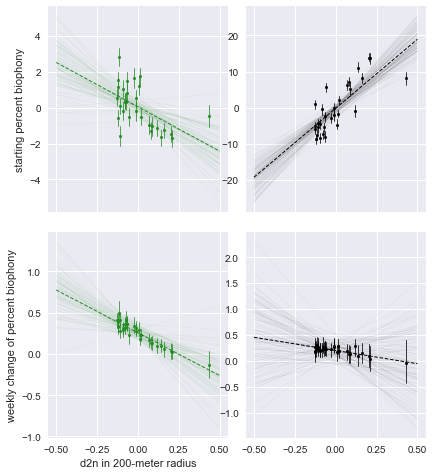

In [22]:
predictor = "d2n_200m"

fig, ax = pyplot.subplots(2, 2, sharex=True, sharey=False)
fig.set_figwidth(6.81)
fig.set_figheight(6.81)
pyplot.subplots_adjust(left=0.19, bottom=0.10, right=0.96, top = 0.98, hspace=0.05, wspace=0.05)

# organize biophony data
biophony_samples = biophony_traces[predictor]
biophony_data = pandas.DataFrame({'site': data_centered.site.unique(), 
                                 'site_name': data_centered.site_name.unique()}).set_index('site')
biophony_data[predictor] = data_centered.groupby('site')[predictor].mean()
biophony_data['quantiles_a'] = [stats.quantiles(biophony_samples.a[5000:, i]) for i in range(len(set(sites)))]
biophony_data['quantiles_b'] = [stats.quantiles(biophony_samples.b[5000:, i]) for i in range(len(set(sites)))]

# organize sel data
sel_samples = sel_traces[predictor]
sel_data = pandas.DataFrame({'site': data_centered.site.unique(), 
                             'site_name': data_centered.site_name.unique()}).set_index('site')
sel_data[predictor] = data_centered.groupby('site')[predictor].mean()
sel_data['quantiles_a'] = [stats.quantiles(sel_samples.a[5000:, i]) for i in range(len(set(sites)))]
sel_data['quantiles_b'] = [stats.quantiles(sel_samples.b[5000:, i]) for i in range(len(set(sites)))]

xd = numpy.array([-0.5, 0.5])

# draw from the posterior distribution and plot
def plot_draws(axis, color, intercept, slope):
    for d in numpy.random.randint(5000, 9999, 100):
        yd = intercept[d] + (xd * slope[d])
        axis.plot(xd, yd, color=color, alpha=0.1, linewidth=0.25)

plot_draws(ax[0, 0], "forestgreen", biophony_samples.g_a, biophony_samples.g_as)
plot_draws(ax[1, 0], "forestgreen", biophony_samples.g_b, biophony_samples.g_bs)
plot_draws(ax[0, 1], "black", sel_samples.g_a, sel_samples.g_as)
plot_draws(ax[1, 1], "black", sel_samples.g_b, sel_samples.g_bs)

# plot quantiles
def plot_quantiles(axis, data, quantiles, color):
    x = data[predictor]
    y = [r[50] for r in data[quantiles]]
    axis.scatter(x, y, color=color, marker='.', zorder=1000, s=30)
    axis.plot([x, x], [[r[25] for r in data[quantiles]], 
                       [r[75] for r in data[quantiles]]], color=color, linewidth=0.75)

plot_quantiles(ax[0, 0], biophony_data, "quantiles_a", "forestgreen")
plot_quantiles(ax[1, 0], biophony_data, "quantiles_b", "forestgreen")
plot_quantiles(ax[0, 1], sel_data, "quantiles_a", "black")
plot_quantiles(ax[1, 1], sel_data, "quantiles_b", "black")

# plot mean regressions
ax[0, 0].plot(xd, biophony_samples.g_a[5000:].mean() + (xd * biophony_samples.g_as[5000:].mean()), 
              color='forestgreen', linestyle='--', linewidth=1)
ax[1, 0].plot(xd, biophony_samples.g_b[5000:].mean() + (xd * biophony_samples.g_bs[5000:].mean()), 
              color='forestgreen', linestyle='--', linewidth=1)
ax[0, 1].plot(xd, sel_samples.g_a[5000:].mean() + (xd * sel_samples.g_as[5000:].mean()), 
              color='black', linestyle='--', linewidth=1)
ax[1, 1].plot(xd, sel_samples.g_b[5000:].mean() + (xd * sel_samples.g_bs[5000:].mean()), 
              color='black', linestyle='--', linewidth=1)

# format plot
yl0 = ax[0, 0].set_ylabel("starting percent biophony")
xl1 = ax[1, 0].set_xlabel("d2n in 200-meter radius")
xl2 = ax[1, 1].set_xlabel("d2n in 200-meter radius")
yl1 = ax[1, 0].set_ylabel("weekly change of percent biophony")

In [21]:
#fig.savefig("/home/ubuntu/download/figure6.tiff", dpi=150)